In [1]:
# import all relevant libraries dependencies and set up the backend
import qsharp
import time
import progressbar
import numpy as np
import matplotlib.pyplot as plt
from qsharp import Result
import exact_diagonalisation.ed_ising as ED 
from Quantum.Isinglongrange import Evolve, EvolveSingleTimestepDummy

c1_a = '#003AF0'
c2_a = '#008F24'
c3_a = '#FE7B22'
c4_a = '#FE000C'
c5_a = '#FB30F2'
c6_a = '#82E0AA'
c7_a = '#9966CC'
c8_a = '#7FFFD4'
c9_a = '#66FF00'
c10_a = '#8B008B'
c11_a = '#000000'
colors = [c1_a,c2_a,c3_a,c4_a,c5_a,c6_a,c7_a,c8_a,c9_a,c10_a,c11_a]

# Time Evolution

Assumes an L x W lattice of sites and expects list length JW to specify hx and hz specified for each site and a matrix J (LW x LW) specified for the couplings. Evolves under Hamiltonian
H ≔ - J Σ'ᵢⱼ Zᵢ Zⱼ - hZ Σᵢ Zᵢ - hX Σᵢ Xᵢ

Can specify the couplings which then builds the J array based on these being the couplings over distance or can specify the J matrix yourself.

Expects initial state of correct shape in 0s and 1s (Z basis) to be specified.

In [13]:
# define system parameters
p = {}
p['L'] = L = 6 # system length
p['W'] = W  = 1 # system width
p['N'] = p['L'] * p['W'] # number of system in the system
p['hx'] = hx = np.array([1. for _ in range(L * W)]) # transverse Ising field for each site 
p['hz'] = hz = np.array([0. for _ in range(L * W)]) # longitudinal Ising field for each site 
couplings = [0., 1., 0.2, 0.5]
J = [[0. for _ in range(L * W)] for _ in range(L * W)]
for i in range(L * W):
    for j in range(L * W):
        s_r, s_c = i // W, i % W
        t_r, t_c = j // W, j % W
        if s_r == t_r:
            h_dist = min([abs(s_c - t_c), W - abs(s_c - t_c)])
            J[i][j] = couplings[h_dist]
        elif s_c == t_c:
            v_dist = min([abs(s_r - t_r), L - abs(s_r - t_r)])
            J[i][j] = couplings[v_dist]
p['J'] = np.asarray(J) # Ising interaction for all sites (i,j)
p['t_initial'] = 0 # begin of time evolution
p['dt'] = dt = 0.005 # time-step
p['t_final'] = total_time = 1.0 # end of time evolution
times = np.linspace(0, total_time, num=11)
# times = np.arange(start=p['t_initial'], stop=(p['t_final']+p['dt']), step=p['dt'])
ave = 500 # measurement count for qsharp meas
initial_state = [[1, 0, 0, 0, 0, 0],]
                 #[0, 0, 0, 0]]
flat_initial_state = [item for sub in initial_state for item in sub]
state_table = ED.generate_state_table(p)

In [14]:
# do exact evolution
tic = time.time()
sim, state_table = ED.evolve(p, state_table, flat_initial_state, kind="list", trotterised=True)
toc = time.time()
print("Exact evolution took ", toc-tic, "s")

Exact evolution took  0.3480687141418457 s


In [15]:
# do qsharp evolution
tic = time.time()
result = np.zeros((len(times), *np.array(initial_state).shape))
progress_bar = progressbar.ProgressBar(max_value=ave)
points_taken = 0
for _ in range(ave):
    for i, t in enumerate(times):
        res = Evolve.simulate(initialState=flat_initial_state,
                              time=t, dt=dt,
                              g=list(hx), h=list(hz), J=J, nested=False)
        result[i] += np.array(res).reshape(np.array(initial_state).shape) / ave
    points_taken += 1
    progress_bar.update(points_taken)
toc = time.time()
print("Q# Evolution took {} mins {} s".format(int((toc-tic) // 60), int((toc-tic) % 60)))

100% (500 of 500) |######################| Elapsed Time: 0:55:26 ETA:  00:00:00

Q# Evolution took 55 mins 38 s


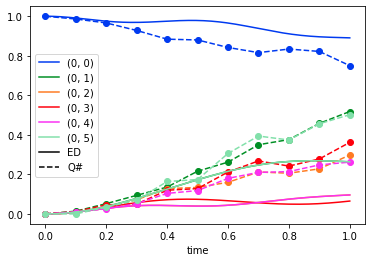

In [19]:
# plot
fig = plt.figure()
qubits = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0,5)]
for i, q in enumerate(qubits):
    site = p['W']*q[0]+q[1]
    site_res = 1 - (sim['Zi Site {}'.format(site)] + 1) / 2
    plt.plot(sim['Time'], site_res, label='{}'.format(q), marker='', linestyle='-', color=colors[i])
    plt.plot(times, result[:, q[0], q[1]], color=colors[i], marker='o', linestyle='--')
    
handles, labels = fig.axes[0].get_legend_handles_labels()
handles = list(handles) + [plt.Line2D((0, 1), (0, 0), color='k', linestyle='-'),
                           plt.Line2D((0, 1), (0, 0), color='k',linestyle='--')]
labels = list(labels) + ['ED', 'Q#']
plt.xlabel('time')
plt.legend(handles, labels)

In [47]:
# estimate resources
full_gatecount = Evolve.estimate_resources(initialState=flat_initial_state,
                                           time=t, dt=dt, g=list(hx), h=list(hz), J=J, nested=False)
timestep_gatecount = EvolveSingleTimestepDummy.estimate_resources(
                        nSites=len(flat_initial_state), dt=dt, g=list(hx), h=list(hz), J=J, nested=False)

print('Full Evolution')
print(*['\t{}: {}\n'.format(k, v) for k, v in full_gatecount.items()])
print('Single Timestep')
print(*['\t{}: {}\n'.format(k, v) for k, v in timestep_gatecount.items()])

Full Evolution
	CNOT: 7200
 	QubitClifford: 1
 	R: 8400
 	Measure: 4
 	T: 0
 	Depth: 0
 	Width: 4
 	BorrowedWidth: 0

Single Timestep
	CNOT: 12
 	QubitClifford: 0
 	R: 14
 	Measure: 0
 	T: 0
 	Depth: 0
 	Width: 4
 	BorrowedWidth: 0



## Outstanding
- Get depth to measure not just T gates